In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [5]:

from dataclasses import replace
import itertools
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, cdist
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from src.analysis import coherence
from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings, load_or_compute_embeddings

In [6]:
model_dir = "outputs/models/w2v2_6_8/syllable"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
# model_dir = "out/ce_model_syllable_6_8"
equiv_dataset_path = "data/timit_equiv_phoneme_6_1.pkl"
output_dir = "."

state_space_spec_path = "out/state_space_specs/all_syllables.pkl"

metric = "cosine"

In [7]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

/home/jgauthier/u/transformers/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [8]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [32]:
with open(state_space_spec_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = pickle.load(f)
assert state_space_spec.is_compatible_with(equiv_dataset)

In [33]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

In [34]:
# Retain only syllables with N or more instances
retain_n = 10
retain_idxs = [idx for idx, target_frames in enumerate(state_space_spec.target_frame_spans)
               if len(target_frames) >= retain_n]
state_space_spec = replace(state_space_spec,
    labels=[state_space_spec.labels[i] for i in retain_idxs],
    target_frame_spans=[state_space_spec.target_frame_spans[i] for i in retain_idxs],
)

In [35]:
spec_label_strs = ["".join(phones) for phones in state_space_spec.labels]

In [36]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, pad=np.nan)

In [37]:
lengths = [np.isnan(traj_i[:, :, 0]).argmax(axis=1) for traj_i in trajectory]

In [38]:
len(trajectory)

887

## Estimate within-syllable distance

In [39]:
within_distance, within_distance_offset = \
    coherence.estimate_within_distance(trajectory, lengths, state_space_spec, metric=metric)

  0%|          | 0/887 [00:00<?, ?it/s]

<Axes: >

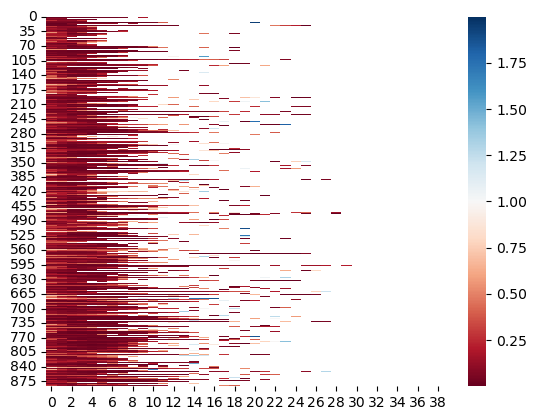

In [40]:
sns.heatmap(within_distance, center=1, cmap="RdBu")

In [41]:
within_distance_df = pd.DataFrame(within_distance, index=pd.Index(spec_label_strs, name="syllable")) \
    .reset_index() \
    .melt(id_vars=["syllable"], var_name="frame", value_name="distance")

In [42]:
within_distance_offset_df = pd.DataFrame(within_distance_offset, index=pd.Index(spec_label_strs, name="syllable")) \
    .reset_index() \
    .melt(id_vars=["syllable"], var_name="frame", value_name="distance")

## Estimate between-syllable distance

In [43]:
between_distance, between_distance_offset = \
    coherence.estimate_between_distance(trajectory, lengths, state_space_spec, metric=metric)

  0%|          | 0/887 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:13: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
between_distances_df = pd.DataFrame(np.nanmean(between_distance, axis=-1),
                                    index=pd.Index(spec_label_strs, name="syllable")) \
    .reset_index() \
    .melt(id_vars=["syllable"], var_name="frame", value_name="distance")

/tmp/ipykernel_1516848/1758874621.py:1: RuntimeWarning: Mean of empty slice
  between_distances_df = pd.DataFrame(np.nanmean(between_distance, axis=-1),


In [22]:
between_distances_offset_df = pd.DataFrame(np.nanmean(between_distance_offset, axis=-1),
                                    index=pd.Index(spec_label_strs, name="syllable")) \
    .reset_index() \
    .melt(id_vars=["syllable"], var_name="frame", value_name="distance")

/tmp/ipykernel_1516848/2358582405.py:1: RuntimeWarning: Mean of empty slice
  between_distances_offset_df = pd.DataFrame(np.nanmean(between_distance_offset, axis=-1),


## Together

In [23]:
merged_df = pd.concat([within_distance_df.assign(type="within"), between_distances_df.assign(type="between")])
merged_df.to_csv(Path(output_dir) / "distances.csv", index=False)
merged_df

,syllable,frame,distance,type
0,SHIH,0,0.094137,within
1,HHEHDJH,0,0.017570,within
2,JHIH,0,0.176764,within
3,DAHK,0,0.013442,within
4,SUWT,0,0.040329,within
...,...,...,...,...
66661,YIHN,40,NaN,between
66662,KIHL,40,NaN,between
66663,GAEB,40,NaN,between
66664,TIHPS,40,NaN,between


Text(0, 0.5, 'Cosine distance')

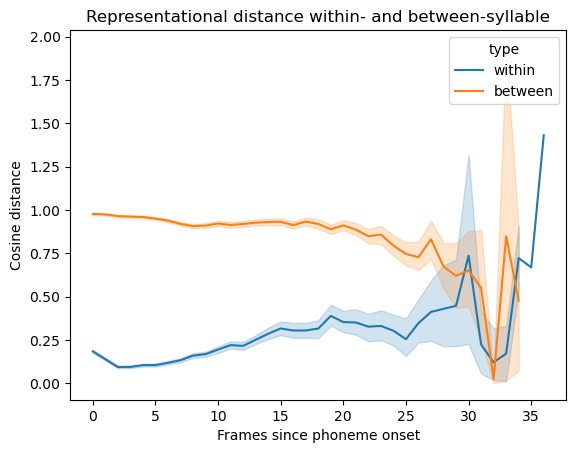

In [24]:
ax = sns.lineplot(data=merged_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance within- and between-syllable")
ax.set_xlabel("Frames since phoneme onset")
ax.set_ylabel(f"{metric.capitalize()} distance")

In [25]:
merged_offset_df = pd.concat([within_distance_offset_df.assign(type="within"), between_distances_offset_df.assign(type="between")])
merged_offset_df.to_csv(Path(output_dir) / "distances_aligned_offset.csv", index=False)
merged_offset_df

,syllable,frame,distance,type
0,SHIH,0,NaN,within
1,HHEHDJH,0,NaN,within
2,JHIH,0,NaN,within
3,DAHK,0,NaN,within
4,SUWT,0,NaN,within
...,...,...,...,...
66661,YIHN,40,NaN,between
66662,KIHL,40,NaN,between
66663,GAEB,40,NaN,between
66664,TIHPS,40,NaN,between


Text(0, 0.5, 'Cosine distance')

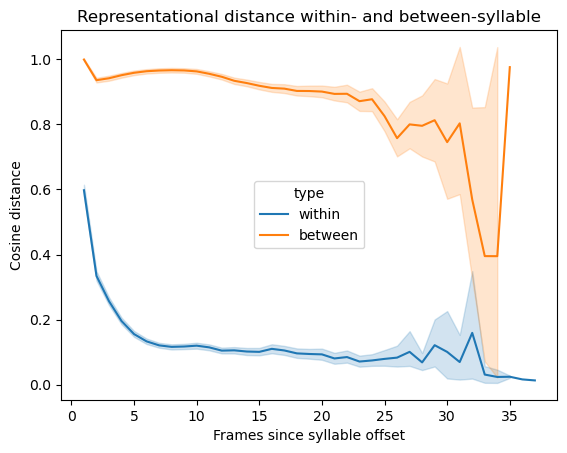

In [26]:
ax = sns.lineplot(data=merged_offset_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance within- and between-syllable")
ax.set_xlabel("Frames since syllable offset")
ax.set_ylabel(f"{metric.capitalize()} distance")

## Estimate between-syllable distance, grouped by features

### Onset

In [48]:
onsets = [syll[0] for syll in state_space_spec.labels]
num_samples = 50
between_onset_samples = []
for onset in onsets:
    mismatched_onset = [idx for idx, syll in enumerate(state_space_spec.labels) if syll[0] != onset]
    between_onset_samples.append(np.random.choice(mismatched_onset, min(num_samples, len(mismatched_onset)), replace=False))

between_onset_distance, between_onset_distance_offset = \
    coherence.estimate_between_distance(trajectory, lengths, state_space_spec,
                                        between_samples=between_onset_samples,
                                        metric=metric)

  0%|          | 0/887 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:13: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [50]:
within_onset_samples = []
for syll in state_space_spec.labels:
    matched_onset = [idx2 for idx2, syll2 in enumerate(state_space_spec.labels) if syll2[0] == syll[0] and syll2 != syll]
    within_onset_samples.append(np.random.choice(matched_onset, min(num_samples, len(matched_onset)), replace=False))

within_onset_distance, within_onset_distance_offset = \
    coherence.estimate_between_distance(trajectory, lengths, state_space_spec,
                                        between_samples=within_onset_samples,
                                        metric=metric)

  0%|          | 0/887 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:13: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [51]:
mismatched_onset_distance_df = pd.DataFrame(np.nanmean(between_onset_distance, axis=-1),
                                            index=pd.Index(spec_label_strs, name="syllable")) \
    .reset_index() \
    .melt(id_vars=["syllable"], var_name="frame", value_name="distance")

/tmp/ipykernel_1516848/2289203928.py:1: RuntimeWarning: Mean of empty slice
  mismatched_onset_distance_df = pd.DataFrame(np.nanmean(between_onset_distance, axis=-1),


In [52]:
matched_onset_distance_df = pd.DataFrame(np.nanmean(within_onset_distance, axis=-1),
                                         index=pd.Index(spec_label_strs, name="syllable")) \
    .reset_index() \
    .melt(id_vars=["syllable"], var_name="frame", value_name="distance")

/tmp/ipykernel_1516848/1973439590.py:1: RuntimeWarning: Mean of empty slice
  matched_onset_distance_df = pd.DataFrame(np.nanmean(within_onset_distance, axis=-1),


In [55]:
merged_onset_match_df = pd.concat([matched_onset_distance_df.assign(type="matched onset"), mismatched_onset_distance_df.assign(type="mismatched onset")])
merged_onset_match_df.to_csv(Path(output_dir) / "distances-grouped_onset.csv", index=False)
merged_onset_match_df

,syllable,frame,distance,type
0,SHIH,0,0.109206,matched onset
1,HHEHDJH,0,0.213290,matched onset
2,JHIH,0,0.175913,matched onset
3,SUWT,0,0.198760,matched onset
4,AHN,0,0.306555,matched onset
...,...,...,...,...
34588,TERT,38,NaN,mismatched onset
34589,KLOW,38,NaN,mismatched onset
34590,LIHK,38,NaN,mismatched onset
34591,SEHP,38,NaN,mismatched onset


Text(0, 0.5, 'Cosine distance')

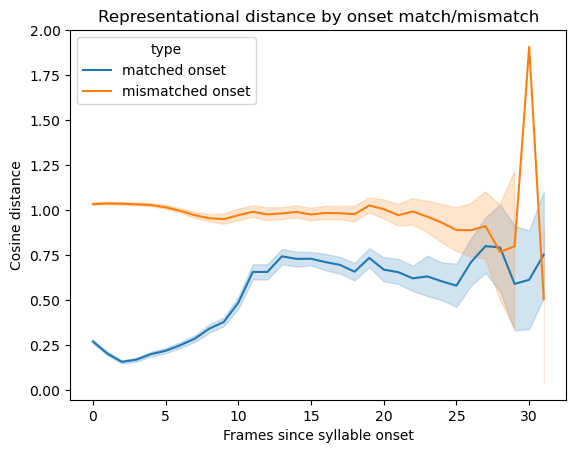

In [56]:
ax = sns.lineplot(data=merged_onset_match_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance by onset match/mismatch")
ax.set_xlabel("Frames since syllable onset")
ax.set_ylabel(f"{metric.capitalize()} distance")

### Nucleus

In [59]:
vowels = ["AA", "AE", "AH", "AO", "AW", "AY", "EH", "ER", "EY", "IH", "IY", "OW", "OY", "UH", "UW"]
nuclei = []
for syll in state_space_spec.labels:
    syll_nucleus = None
    for phone in syll:
        if phone in vowels:
            syll_nucleus = phone
            break
    nuclei.append(syll_nucleus)

In [60]:
pd.Series(nuclei).value_counts()

IH    180
AH    108
EH     84
AE     72
IY     68
ER     65
AA     50
UW     47
AY     47
EY     45
AO     43
OW     35
UH     16
AW     16
OY      9
Name: count, dtype: int64

In [61]:
num_samples = 50
between_nucleus_samples = []
for nucleus in nuclei:
    mismatched_nucleus = [idx2 for idx2, nucl2 in enumerate(nuclei) if nucl2 != nucleus]
    between_nucleus_samples.append(np.random.choice(mismatched_nucleus, min(num_samples, len(mismatched_nucleus)), replace=False))

between_nucleus_distance, between_nucleus_distance_offset = \
    coherence.estimate_between_distance(trajectory, lengths, state_space_spec,
                                        between_samples=between_nucleus_samples,
                                        metric=metric)

  0%|          | 0/887 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:13: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [62]:
within_nucleus_samples = []
for nucleus, syll in zip(nuclei, state_space_spec.labels):
    matched_nucleus = [idx2 for idx2, (nucl2, syll2) in enumerate(zip(nuclei, state_space_spec.labels))
                       if nucl2 == nucleus and syll2 != syll]
    within_nucleus_samples.append(np.random.choice(matched_nucleus, min(num_samples, len(matched_nucleus)), replace=False))

within_nucleus_distance, within_nucleus_distance_offset = \
    coherence.estimate_between_distance(trajectory, lengths, state_space_spec,
                                        between_samples=within_nucleus_samples,
                                        metric=metric)

  0%|          | 0/887 [00:00<?, ?it/s]

In [71]:
mismatched_nucleus_distance_df = pd.DataFrame(np.nanmean(between_nucleus_distance, axis=-1),
                                            index=pd.Index(spec_label_strs, name="syllable")) \
    .reset_index() \
    .melt(id_vars=["syllable"], var_name="frame", value_name="distance")

/tmp/ipykernel_1516848/1452674008.py:1: RuntimeWarning: Mean of empty slice
  mismatched_nucleus_distance_df = pd.DataFrame(np.nanmean(between_nucleus_distance, axis=-1),


In [72]:
matched_nucleus_distance_df = pd.DataFrame(np.nanmean(within_nucleus_distance, axis=-1),
                                            index=pd.Index(spec_label_strs, name="syllable")) \
        .reset_index() \
        .melt(id_vars=["syllable"], var_name="frame", value_name="distance")

/tmp/ipykernel_1516848/2139597224.py:1: RuntimeWarning: Mean of empty slice
  matched_nucleus_distance_df = pd.DataFrame(np.nanmean(within_nucleus_distance, axis=-1),


In [73]:
merged_nucleus_match_df = pd.concat([matched_nucleus_distance_df.assign(type="matched nucleus"), mismatched_onset_distance_df.assign(type="mismatched nucleus")])
merged_nucleus_match_df.to_csv(Path(output_dir) / "distances-grouped_nucleus.csv", index=False)
merged_nucleus_match_df

,syllable,frame,distance,type
0,SHIH,0,0.783203,matched nucleus
1,HHEHDJH,0,0.918349,matched nucleus
2,JHIH,0,1.016677,matched nucleus
3,SUWT,0,0.853141,matched nucleus
4,AHN,0,1.149426,matched nucleus
...,...,...,...,...
34588,TERT,38,NaN,mismatched nucleus
34589,KLOW,38,NaN,mismatched nucleus
34590,LIHK,38,NaN,mismatched nucleus
34591,SEHP,38,NaN,mismatched nucleus


Text(0, 0.5, 'Cosine distance')

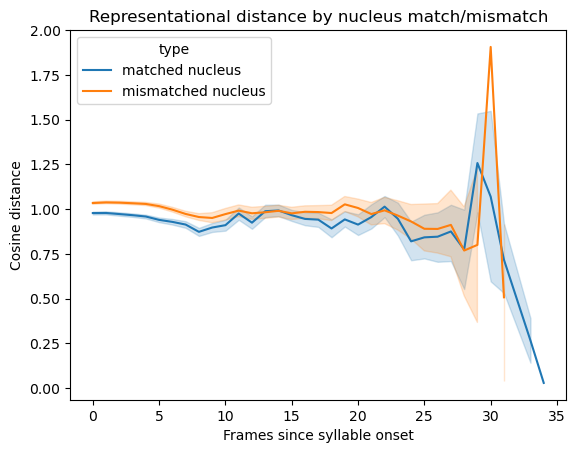

In [74]:
ax = sns.lineplot(data=merged_nucleus_match_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance by nucleus match/mismatch")
ax.set_xlabel("Frames since syllable onset")
ax.set_ylabel(f"{metric.capitalize()} distance")

### Onset2

In [82]:
syll_mask = np.array([len(syll) > 2 for syll in state_space_spec.labels])
traj_subset = [trajectory[idx] for idx in syll_mask.nonzero()[0]]
lengths_subset = [lengths[idx] for idx in syll_mask.nonzero()[0]]
labels_subset = [state_space_spec.labels[idx] for idx in syll_mask.nonzero()[0]]

onsets2 = [syll[:2] for syll in labels_subset]

matched_onset2_samples, mismatched_onset2_samples = [], []
for syll, onset2 in zip(labels_subset, onsets2):
    matched_onset2_samples_i = [idx2 for idx2, (syll2, onset2_2) in enumerate(zip(labels_subset, onsets2))
                              if syll2 != syll and onset2_2 == onset2]
    mismatched_onset2_samples_i = [idx2 for idx2, (syll2, onset2_2) in enumerate(zip(labels_subset, onsets2))
                                 if onset2_2 != onset2]

    matched_onset2_samples.append(np.random.choice(matched_onset2_samples_i, min(num_samples, len(matched_onset2_samples_i)), replace=False))
    mismatched_onset2_samples.append(np.random.choice(mismatched_onset2_samples_i, min(num_samples, len(mismatched_onset2_samples_i)), replace=False))

In [83]:
matched_onset2_distance, matched_onset2_distance_offset = \
    coherence.estimate_between_distance(traj_subset, lengths_subset, state_space_spec,
                                        between_samples=matched_onset2_samples,
                                        metric=metric)

  0%|          | 0/593 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:13: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [84]:
mismatched_onset2_distance, mismatched_onset2_distance_offset = \
    coherence.estimate_between_distance(traj_subset, lengths_subset, state_space_spec,
                                        between_samples=mismatched_onset2_samples,
                                        metric=metric)

  0%|          | 0/593 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:13: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [85]:
mismatched_onset2_distance_df = pd.DataFrame(np.nanmean(mismatched_onset2_distance, axis=-1),
                                            index=pd.Index(["".join(label) for label in labels_subset], name="syllable")) \
    .reset_index() \
    .melt(id_vars=["syllable"], var_name="frame", value_name="distance")
matched_onset2_distance_df = pd.DataFrame(np.nanmean(matched_onset2_distance, axis=-1),
                                          index=pd.Index(["".join(label) for label in labels_subset], name="syllable")) \
    .reset_index() \
    .melt(id_vars=["syllable"], var_name="frame", value_name="distance")

/tmp/ipykernel_1516848/525058613.py:1: RuntimeWarning: Mean of empty slice
  mismatched_onset2_distance_df = pd.DataFrame(np.nanmean(mismatched_onset2_distance, axis=-1),
/tmp/ipykernel_1516848/525058613.py:5: RuntimeWarning: Mean of empty slice
  matched_onset2_distance_df = pd.DataFrame(np.nanmean(matched_onset2_distance, axis=-1),


In [86]:
merged_onset2_match_df = pd.concat([matched_onset2_distance_df.assign(type="matched onset2"), mismatched_onset2_distance_df.assign(type="mismatched onset2")])
merged_onset2_match_df.to_csv(Path(output_dir) / "distances-grouped_onset2.csv", index=False)
merged_onset2_match_df

,syllable,frame,distance,type
0,HHEHDJH,0,0.056349,matched onset2
1,SUWT,0,0.180809,matched onset2
2,GRIH,0,0.038775,matched onset2
3,WAOSH,0,0.025290,matched onset2
4,AESK,0,NaN,matched onset2
...,...,...,...,...
23122,TERT,38,NaN,mismatched onset2
23123,KLOW,38,NaN,mismatched onset2
23124,LIHK,38,NaN,mismatched onset2
23125,SEHP,38,NaN,mismatched onset2


Text(0, 0.5, 'Cosine distance')

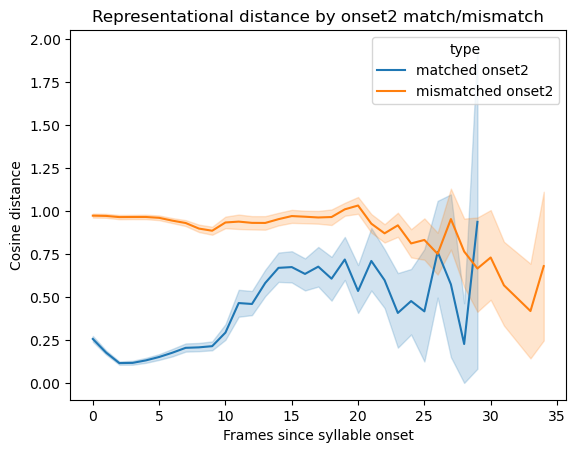

In [88]:
ax = sns.lineplot(data=merged_onset2_match_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance by onset2 match/mismatch")
ax.set_xlabel("Frames since syllable onset")
ax.set_ylabel(f"{metric.capitalize()} distance")

## RSA

In [27]:
num_frames = trajectory[0].shape[1]

syllable_length = 2
all_syllables = sorted([label for label in state_space_spec.labels if len(label) == syllable_length])

# Prepare balanced sample of representations for each syllable in each category
num_instances = min(len(state_space_spec.target_frame_spans[state_space_spec.labels.index(syllable)])
                    for syllable in all_syllables)

syllable_representations = {}
for syllable in all_syllables:
    sample_instance_idxs = np.random.choice(len(state_space_spec.target_frame_spans[state_space_spec.labels.index(syllable)]),
                                            num_instances, replace=False)
    syllable_representations[syllable] = np.array([trajectory[state_space_spec.labels.index(syllable)][idx]
                                                   for idx in sample_instance_idxs])

# Compute between-phoneme distances
from src.analysis.coherence import get_mean_distance
distances = np.zeros((len(all_syllables), len(all_syllables), trajectory[0].shape[1]))
for p1, p2 in tqdm(list(itertools.product(list(range(len(all_syllables))), repeat=2))):
    if p1 == p2:
        continue
    for k in range(num_frames):
        distances[p1, p2, k] = get_mean_distance(syllable_representations[all_syllables[p1]][:, k, :],
                                                 syllable_representations[all_syllables[p2]][:, k, :], metric=metric)

  0%|          | 0/116281 [00:00<?, ?it/s]

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


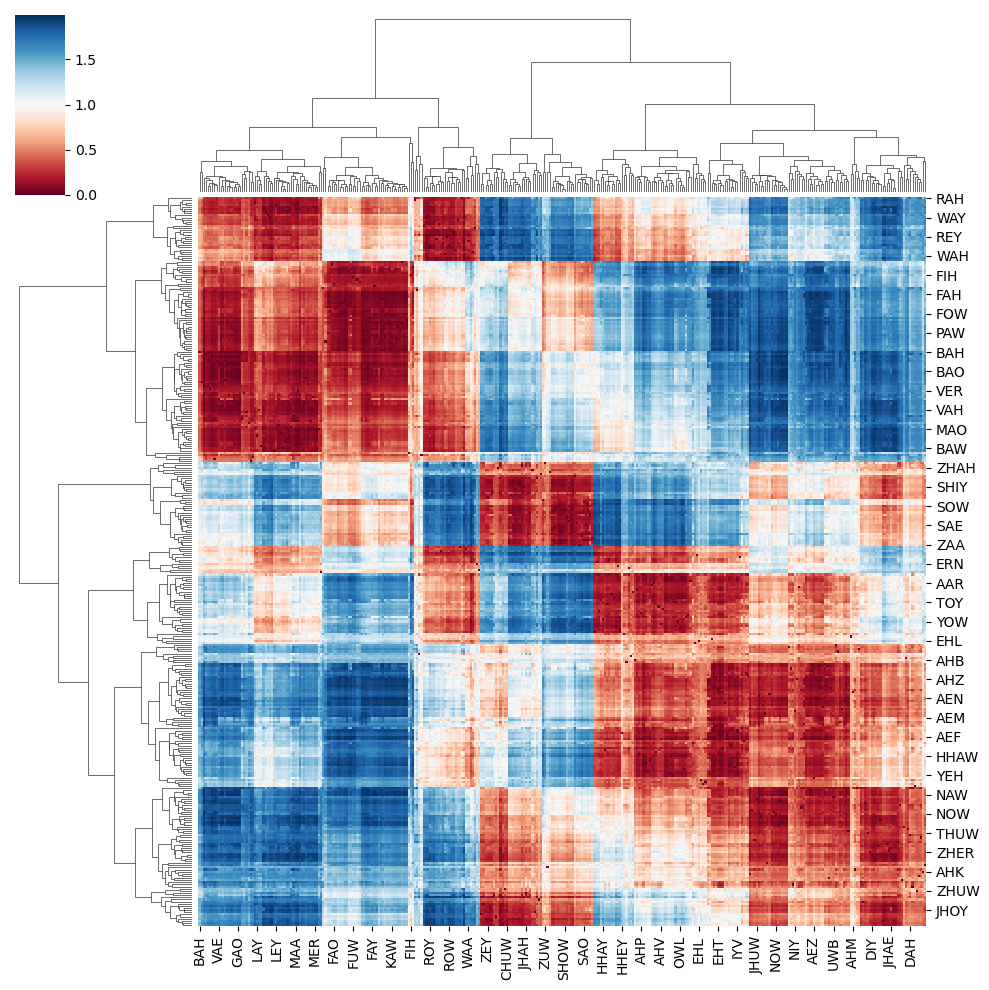

In [28]:
all_syllable_labels = ["".join(phones) for phones in all_syllables]
sns.clustermap(pd.DataFrame(np.nanmean(distances, axis=-1), index=all_syllable_labels, columns=all_syllable_labels),
               center=1, cmap="RdBu")

<Figure size 1000x1000 with 0 Axes>

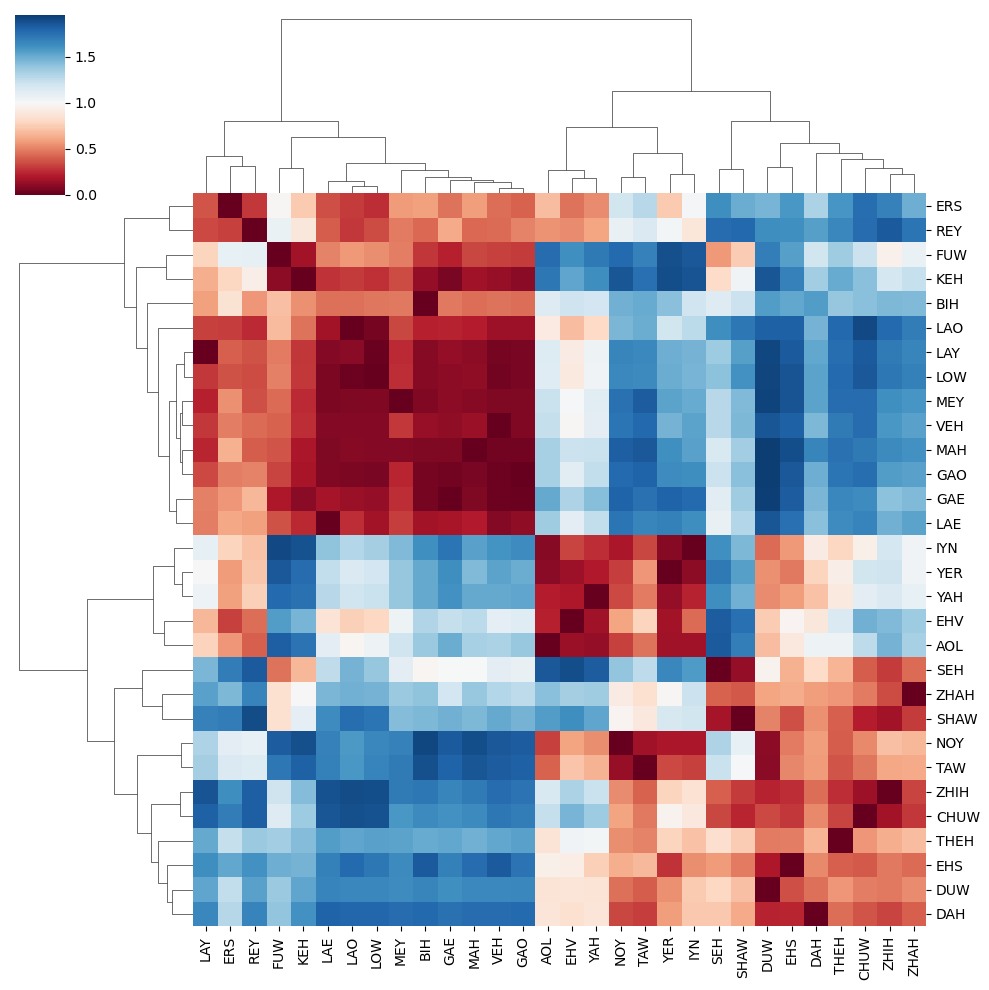

In [89]:
plot_subset = np.random.choice(len(all_syllable_labels), size=30, replace=False)
plt.figure(figsize=(10, 10))
sns.clustermap(np.nanmean(distances, axis=-1)[plot_subset][:, plot_subset], center=1, cmap="RdBu",
            xticklabels=[all_syllable_labels[i] for i in plot_subset],
            yticklabels=[all_syllable_labels[i] for i in plot_subset])